# Predicting a biological response

The dataset used in this project comes from : https://www.kaggle.com/c/bioresponse/data

## 1 - Context

Experimentations in laboratories are getting more and more expensive due to the advance in technology. The goal behind this project is to find links between molecular information and an actual biological response.

Let's get a look at the data :

In [3]:
import pandas as pd
import os
os.chdir('C:/Users/Idriss/Desktop/3A/OMA/Optimisation')

In [4]:
data = pd.read_csv('train_biology.csv')

In [5]:
data.shape

(3751, 1777)

As we can see, we have 3751 samples and 1777 features

#### Distribution of the target variable : Activity

In [6]:
data['Activity'].value_counts(1)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

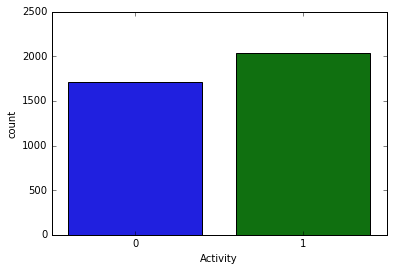

In [11]:
sns.countplot(x = 'Activity',data = data)
plt.show()

Our target variable is not unbalanced. If it was the case, we'd have to do some preprocessing (under-sampling, over-sampling)

## 2 - SVM Theory

In this project, we will use Support Vector Machines algorithms for classification. We often have to deal with **'small n, large p'** problems in contexts related to biology. This motivates our use of the dual form for SVM algorithm.

## 2-1 Primal formulation of the soft-margin SVM

We will formulate the primal problem of the soft-margin SVM (enabling some points to be misclassified)

The goal is to minimize :
$$\frac{1}{2} \| \textbf{w} \|^2 + C\sum_{i=1}^ne_i$$
$$ s.t.\ \         y_i(w^Tx_i +b) \geq 1 - e_i$$
$$ \\\ e_i \geq 0$$

where :  $$e_i = 1 - y_i(w^Tx_i +b)$$

We see that the minimization happens in the features' space.

## 2-2 Dual formulation of the soft-margin SVM

Here the goal is to minimize :
$$ q(\alpha) = \sum_{i=1}^n\alpha_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_iy_jx_ix_j$$
under the constraints : 
  $$  0 \leq \alpha_i \leq C \ \ \ for \ \ i = 1,...n$$
  $$ \sum_{i=1}^n \alpha_iy_i = 0  $$

This will be the optimisation problem solved in this project.

## 3- Implementation of the dual form using CVXOPT 

Links related to CVXOPT :
 - http://cvxopt.org/userguide/coneprog.html
 - https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

The convex optimisation problem that CVXOPT enables to solve is :
 
$$ minimize \ \ \frac{1}{2} x^TPx + q^Tx$$
$$ $$
$$ \ \ s.t \ \ Gx \leq h \ \ ; \ \  Ax = b$$

Add the expressions of P, q , G, h , A and b

Let us define P, q, H, h, A and b in our dual formulation :

 $$  P[i,j] = y_i y_j \ K(x_i,x_j) \ for \ 1 \leq i \leq n \ and \ 1 \leq j \leq n$$
 $$  q[i] = -1 \ for \ 1 \leq i \leq n $$ 
 $$  G[i,i] = 1 \ for  \ 1 \leq i \leq n \ and \ 1 \leq j \leq n \ ; \ G[i,i] = -1  \ for  \ n \leq i \leq 2n \ and \ 1 \leq j \leq n  \  ; \ 0 \ elsewhere $$
 $$  A[i] = y_i \ for \ 1 \leq i \leq n $$
 $$  b = 0 $$

In [6]:
import numpy as np
import cvxopt as cvx

from math import exp

## 3-1 Utils class : Kernels and Inner matrix computation

In [7]:
class utils: 
    
    def compute_inner_matrix(self,X,kernel):
        '''
        Compute the matrix containing inner products using kernel defined in the object

        Parameters
        ----------

        X : array-like, shape = [n_samples, n_features]
         Training vector, where n_samples in the number of samples and
         n_features is the number of features.
         
        kernel : kernel function

       Returns
       -------
        inner_matrix : array_like, shape = [n_samples,n_samples]

        '''

        X = np.array(X)

        n = X.shape[0]

        inner_matrix = np.zeros((n,n))

        for i in range(n):
            for j in range(n):
                inner_matrix[i,j] = kernel(X[i],X[j])

        return inner_matrix
    
    def linear_kernel(self,x,y):
        '''
        Implement the linear kernel method
    
        Returns
        -------
        linear : function, linear kernel
    
        '''
        '''
        Compute the inner product 
        '''
        return np.dot(x,y)
    
    
    
    def gaussian_kernel(self,x,y,gamma):
        '''
        Implement the linear kernel method
    
        Parameters
        ----------
        x,y : array-like , must have same dimensions
        
        gamma : 1/(2*sigma**2) where sigma is a free parameter and can be seen as the standard deviation of the gaussian distribution
    
        Returns
        -------
        gaussian : function, gaussian kernel
    
        '''
    
    
        dist = np.linalg.norm(np.array(x)-np.array(y),ord = None)**2
    
        return exp(-gamma*dist)

## 3-2 SVM Classifier

In [8]:
class SVMClassifier:
    
    #Dual form : To use when n << p
    
    def __init__(self,C,kernel,threshold_SV):
        self.C = float(C)
        self.kernel = kernel
        self.threshold_SV = threshold_SV
    
    utils_ = utils()

    def compute_lagrange_factors(self,X,y):
        '''
        Compute the lagrange multipliers (alpha_i)

        Parameters
        ----------

        X : array-like, shape = [n_samples, n_features]
             Training vector, where n_samples in the number of samples and
             n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target vector relative to X

        Returns
        -------
        alpha : vector of the coefficients

        '''

        #Here we will use the cvxopt python library. We will use its matrix objects cvx.matrix

        n = X.shape[0]

        inner_product_matrix = utils_.compute_inner_matrix(X,self.kernel)

        P = cvx.matrix(np.outer(y,y)*inner_product_matrix , tc = 'd')

        q = cvx.matrix(-1 * np.ones(n),tc = 'd')
        
        G_1 = np.identity(n)
        G_2 = np.identity(n)*(-1)
        G = cvx.matrix(np.vstack((G_1,G_2)),tc = 'd')

        h = cvx.matrix(np.array([self.C]*n+[0.0]*n),tc = 'd')
        
        A = cvx.matrix(y, (1,n),tc = 'd') 
        
        b = cvx.matrix(0.0)

        sol = np.array(cvx.solvers.qp(P,q,G,h,A,b)['x']).flatten()

        return sol


    def fit(self,X,y):

        '''
        Fit the SVM model on the dataset

        Parameters
        ----------

        X : array-like, shape = [n_samples, n_features]
             Training vector, where n_samples in the number of samples and
             n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target vector relative to X

        Returns
        -------
        alpha : vector of the coefficients

        '''
        
        if isinstance(X,pd.core.frame.DataFrame):
            X = X.values

        y = np.array(y)
            
        self.alpha = self.compute_lagrange_factors(X,y)

        self.alpha_support = self.alpha[self.alpha > self.threshold_SV]

        self.support_vectors = X[np.argwhere(self.alpha > self.threshold_SV)].reshape(-1,X.shape[1])

        self.support_vectors_labels = y[np.argwhere(self.alpha > self.threshold_SV)]
        
        temp = []
        for x_sv,y_sv in zip(self.support_vectors,self.support_vectors_labels):
            output = 0
            for (alpha,x_,y_) in zip(self.alpha_support,self.support_vectors,self.support_vectors_labels):
                output += alpha * y_ * np.dot(x_,x_sv)
            temp.append(y_sv - np.sign(output))
            
        self.bias = np.mean(temp)

        return self


    def predict(self,X):

        """
        Perform classification on samples in X.
        +1 or -1 is returned.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)

        Returns
        -------
        y_pred : array, shape (n_samples,)
            Class labels for samples in X.
        """
        
        if isinstance(X,pd.core.frame.DataFrame):
            X = X.values
        
        y_pred = []
        
        for i in range(X.shape[0]):
            output = self.bias
            for (alpha,x_,y_) in zip(self.alpha_support,self.support_vectors,self.support_vectors_labels):
                output += alpha * y_ * np.dot(x_,X[i])
            y_pred.extend(np.sign(output))

        return y_pred

## 4- Application on data

### 4-1 Definition of the training and test sets

In [9]:
X = data.drop('Activity',axis = 1)
y = data['Activity'].apply(lambda x: -1 if x == 0 else x)

X_train = X.iloc[:500]
y_train = y.iloc[:500]

X_test = X.iloc[500:700]
y_test = y.iloc[500:700]

print('The shape of the training set is ',X_train.shape)
print('The shape of the test set is ',X_test.shape)

The shape of the training set is  (500, 1776)
The shape of the test set is  (200, 1776)


### 4-2 Linear Kernel

In [10]:
utils_ = utils()

In [11]:
np.random.seed(42)

C_unif = np.random.uniform(0.05,10,10)

In [12]:
from sklearn.metrics import precision_score,recall_score

In [28]:
dic_scores = {}

for C in C_unif:
    
    SVM = SVMClassifier(C = C,kernel = utils_.linear_kernel,threshold_SV = 10**(-4))

    SVM.fit(X_train,y_train)

    y_pred_ = SVM.predict(X_test)
    
    precision = precision_score(y_test,y_pred_)
    
    recall = recall_score(y_test,y_pred_)
    
    dic_scores[C] = [precision,recall]

     pcost       dcost       gap    pres   dres
 0: -1.8450e+01 -4.9825e+03  1e+04  8e-01  5e-13
 1:  3.4249e+01 -1.8675e+03  3e+03  1e-01  3e-13
 2:  9.7394e+00 -5.1010e+02  6e+02  2e-02  2e-13
 3: -3.4530e+01 -1.5150e+02  1e+02  3e-03  2e-13
 4: -4.8899e+01 -8.0040e+01  3e+01  6e-04  1e-13
 5: -5.3907e+01 -6.0107e+01  6e+00  5e-05  2e-13
 6: -5.5056e+01 -5.6254e+01  1e+00  8e-06  1e-13
 7: -5.5330e+01 -5.5403e+01  7e-02  3e-07  1e-13
 8: -5.5349e+01 -5.5356e+01  7e-03  1e-08  1e-13
 9: -5.5350e+01 -5.5351e+01  2e-04  3e-10  1e-13
10: -5.5351e+01 -5.5351e+01  4e-06  4e-12  2e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.0097e+02 -2.1753e+04  5e+04  5e-01  1e-12
 1:  6.1520e+02 -6.5947e+03  1e+04  8e-02  6e-13
 2:  2.7314e+02 -1.6701e+03  2e+03  1e-02  5e-13
 3:  2.9777e+01 -3.8503e+02  4e+02  1e-03  3e-13
 4: -4.0990e+01 -1.1242e+02  7e+01  1e-04  2e-13
 5: -5.4698e+01 -7.2109e+01  2e+01  2e-05  2e-13
 6: -5.7728e+01 -6.3679e+01  6e+00  6e-06  2e-1

In [41]:
precision_history = np.array(list(dic_scores.values()))[:,0]
recall_history = np.array(list(dic_scores.values()))[:,1]

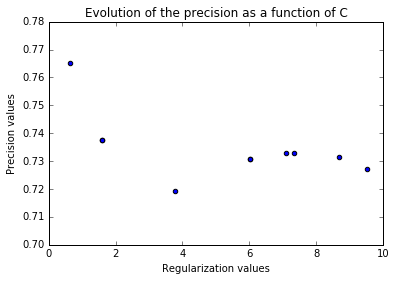

In [50]:
plt.scatter(np.array(list(dic_scores.keys())),precision_history)
plt.xlabel('Regularization values')
plt.ylabel('Precision values')
plt.title('Evolution of the precision as a function of C')

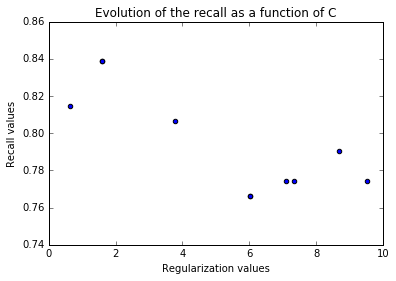

In [52]:
plt.scatter(np.array(list(dic_scores.keys())),recall_history)
plt.xlabel('Regularization values')
plt.ylabel('Recall values')
plt.title('Evolution of the recall as a function of C')

In biology context, the precision is more important than the recall because we want as few false alarms as possible.

The best score for the linear kernel is then given by ** C = 0.6 ** : 
- Precision = 0.76
- Recall = 0.81

### 4-3 Gaussian Kernel

In [16]:
import itertools
from functools import partial

In [19]:
dic_scores_2 = {}

C_unif = np.random.uniform(0.05,10,10)

gamma_unif = np.random.uniform(0.005,1,5)

for C,gamma in itertools.product(C_unif,gamma_unif):
    
    gaussian_kernel = partial(utils_.gaussian_kernel,gamma = gamma)
    
    SVM = SVMClassifier(C = C,kernel = gaussian_kernel,threshold_SV = 10**(-4))

    SVM.fit(X_train,y_train)

    y_pred_ = SVM.predict(X_test)
    
    precision = precision_score(y_test,y_pred_)
    
    recall = recall_score(y_test,y_pred_)
    
    dic_scores_2[(C,gamma)] = [precision,recall]

     pcost       dcost       gap    pres   dres
 0: -1.9161e+02 -2.9689e+03  3e+03  2e-14  2e-15
 1: -2.2806e+02 -4.6218e+02  2e+02  5e-15  6e-16
 2: -2.4134e+02 -2.5504e+02  1e+01  1e-14  3e-16
 3: -2.4148e+02 -2.4176e+02  3e-01  1e-14  3e-16
 4: -2.4149e+02 -2.4149e+02  4e-03  5e-15  2e-16
 5: -2.4149e+02 -2.4149e+02  5e-05  3e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9216e+02 -2.9531e+03  3e+03  2e-14  2e-15
 1: -2.2840e+02 -4.5560e+02  2e+02  5e-14  5e-16
 2: -2.4148e+02 -2.5454e+02  1e+01  2e-14  3e-16
 3: -2.4160e+02 -2.4184e+02  2e-01  7e-15  3e-16
 4: -2.4160e+02 -2.4161e+02  3e-03  1e-15  2e-16
 5: -2.4160e+02 -2.4160e+02  3e-05  2e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9009e+02 -3.0110e+03  3e+03  4e-14  2e-15
 1: -2.2714e+02 -4.7578e+02  2e+02  6e-14  6e-16
 2: -2.4099e+02 -2.5556e+02  1e+01  2e-14  4e-16
 3: -2.4117e+02 -2.4149e+02  3e-01  4e-15  3e-16
 4: -2.4118e+02 -2.4118e

In [62]:
dic_2 = {}
for key,value in dic_scores_2.items():
    if value not in dic_2.values():
        dic_2[key] = value

In [63]:
precision_history = np.array(list(dic_2.values()))[:,0]
recall_history = np.array(list(dic_2.values()))[:,1]
C_gamma_history = [str(list(dic_2.keys())[i]) for i in range(len(dic_2.keys()))]

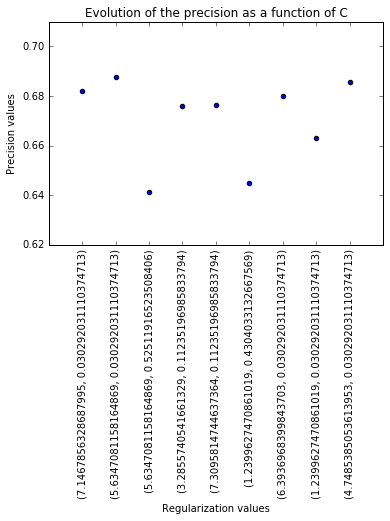

In [64]:
x = range(len(C_gamma_history))
plt.scatter(x,precision_history)
plt.xlabel('Regularization values')
plt.ylabel('Precision values')
plt.xticks(x, C_gamma_history)
plt.xticks(rotation=90)
plt.title('Evolution of the precision as a function of C')

The best score for the gaussian kernel is given by ** C = 5.63 and gamma = 0.03 ** : 
- Precision = 0.69
- Recall = 0.96

## 5- Conclusion

As mentioned earlier, the choice of the model will be based on the precision score.
Hence we choose using the **linear kernel** and **C = 0.6**.